In [7]:
import seaborn as sns
import pandas as pd


from sklearn import set_config
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier

set_config(display="diagram")

# Hyperparameter tuning by grid-search

There are many parameters that need to be tuned when building a machine-learning model.

- It is non-intuitive what these parameters should be


## Example: Adults Census Data

This is a dataset that contains information from the 1994 Census. The goal is to predict if a person makes more than \$50,000 per year based on their demographic information.


### Step 1: Load the Data


In [8]:
adult_census = pd.read_csv("./data/adult-census.csv")

### Step 2: Visualize and Clean the Data


We extract the column containing the target.


In [9]:
target_name = "class"
target = adult_census[target_name]
target

0         <=50K
1         <=50K
2          >50K
3          >50K
4         <=50K
          ...  
48837     <=50K
48838      >50K
48839     <=50K
48840     <=50K
48841      >50K
Name: class, Length: 48842, dtype: object

We drop from our data the target and the `"education-num"` column which
duplicates the information from the `"education"` column.


In [11]:
data = adult_census.drop(columns=[target_name, "education-num"])
data.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,Some-college,Never-married,?,Own-child,White,Female,0,0,30,United-States


### Step 3: Test Train Split


Once the dataset is loaded, we split it into training and testing sets.


In [12]:
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42)

### Step 4: Building a Pipeline

Within Scikit-learn there are tools to build a pipeline to automate preprocessing and data analysis.


We will define a pipeline. It will handle both numerical and categorical features.

The first step is to select all the categorical columns.


In [13]:
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

Here we will use a tree-based model as a classifier
(i.e. `HistGradientBoostingClassifier`). That means:

- Numerical variables don't need scaling;
- Categorical variables can be dealt with by an `OrdinalEncoder` even if the
  coding order is not meaningful;
- For tree-based models, the `OrdinalEncoder` avoids having high-dimensional
  representations.

We now build our `OrdinalEncoder` by passing it to the known categories.


In [14]:
categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)

We then use a `ColumnTransformer` to select the categorical columns and apply the `OrdinalEncoder` to them.

- The `ColumnTransformer` applies a transformation to the columns of a Pandas dataframe.


In [15]:
preprocessor = ColumnTransformer([
    ('cat_preprocessor', categorical_preprocessor, categorical_columns)],
    remainder='passthrough', sparse_threshold=0)

Finally, we use a tree-based classifier (i.e. histogram gradient-boosting) to
predict whether or not a person earns more than 50 k$ a year.


In [16]:
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier",
     HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4))])
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

### Step 5: Tuning the Model Using GridSearch

- `GridSearchCV` is a scikit-learn class that implements a very similar logic with less repetitive code.

Let's see how to use the `GridSearchCV` estimator for doing such a search. Since the grid search will be costly, we will only explore the combination learning rate and the maximum number of nodes.


In [17]:
%%time
param_grid = {
    'classifier__learning_rate': (0.01, 0.1, 1, 10),
    'classifier__max_leaf_nodes': (3, 10, 30)}
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=2)
model_grid_search.fit(data_train, target_train)

CPU times: total: 12 s
Wall time: 5.99 s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'sex',
                                                                          'native-country'])])),
                                       ('classifier',
                                        HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                                       random_state=42))]),
             n_jobs=2,
             param_grid={'classifier__learning_rate': (0.01, 0.1, 1, 10),
                         'classifier__max_leaf_nodes': (3, 10, 30)})

### Step 6: Validation of the Model


Finally, we will check the accuracy of our model using the test set.


In [18]:
accuracy = model_grid_search.score(data_test, target_test)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.88


<div class="admonition warning alert alert-danger">
<p class="first admonition-title" style="font-weight: bold;">Warning</p>
<p>Be aware that the evaluation should normally be performed through
cross-validation by providing <tt class="docutils literal">model_grid_search</tt> as a model to the
<tt class="docutils literal">cross_validate</tt> function.</p>
<p class="last">Here, we used a single train-test split to evaluate <tt class="docutils literal">model_grid_search</tt>.
If interested you can look into more detail about nested cross-validation,
when you use cross-validation both for hyperparameter tuning and model
evaluation.</p>
</div>


The `GridSearchCV` estimator takes a `param_grid` parameter which defines
all hyperparameters and their associated values. The grid search will be in
charge of creating all possible combinations and testing them.


The number of combinations will be equal to the product of the
number of values to explore for each parameter (e.g. in our example 4 x 3
combinations). Thus, adding new parameters with their associated values to be
explored become rapidly computationally expensive.


Once the grid search is fitted, it can be used as any other predictor by
calling `predict` and `predict_proba`. Internally, it will use the model with
the best parameters found during the `fit`.


Get predictions for the 5 first samples using the estimator with the best
parameters.


In [19]:
model_grid_search.predict(data_test.iloc[0:5])

array([' <=50K', ' <=50K', ' >50K', ' <=50K', ' >50K'], dtype=object)

You can know about these parameters by looking at the `best_params_`
attribute.


In [20]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'classifier__learning_rate': 0.1, 'classifier__max_leaf_nodes': 30}


In addition, we can inspect all results which are stored in the attribute
`cv_results_` of the grid-search. We will filter some specific columns
from these results.


In [21]:
cv_results = pd.DataFrame(model_grid_search. ).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_leaf_nodes,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
5,0.521143,0.039066,0.078828,0.007809,0.1,30,"{'classifier__learning_rate': 0.1, 'classifier...",0.868912,0.867213,0.868063,0.000850,1
4,0.251043,0.001984,0.076337,0.007820,0.1,10,"{'classifier__learning_rate': 0.1, 'classifier...",0.866783,0.866066,0.866425,0.000359,2
7,0.082027,0.000023,0.074337,0.003792,1,10,"{'classifier__learning_rate': 1, 'classifier__...",0.858648,0.862408,0.860528,0.001880,3
6,0.092489,0.011621,0.064005,0.000003,1,3,"{'classifier__learning_rate': 1, 'classifier__...",0.859358,0.859514,0.859436,0.000078,4
8,0.122914,0.008624,0.065761,0.003249,1,30,"{'classifier__learning_rate': 1, 'classifier__...",0.855536,0.856129,0.855832,0.000296,5


Let us focus on the most interesting columns and shorten the parameter
names to remove the `"param_classifier__"` prefix for readability:


In [22]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [23]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,learning_rate,max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
5,0.1,30,0.868063,0.000850,1
4,0.1,10,0.866425,0.000359,2
7,1,10,0.860528,0.001880,3
6,1,3,0.859436,0.000078,4
8,1,30,0.855832,0.000296,5
3,0.1,3,0.853266,0.000515,6
2,0.01,30,0.843330,0.002917,7
1,0.01,10,0.817832,0.001124,8
0,0.01,3,0.797166,0.000715,9
11,10,30,0.288200,0.050539,10


### Step 7: Visualizing Hyperparameter Tuning


With only 2 parameters, we might want to visualize the grid search as a
heatmap. We need to transform our `cv_results` into a dataframe where:

- the rows will correspond to the learning-rate values;
- the columns will correspond to the maximum number of leaf;
- the content of the dataframe will be the mean test scores.


In [24]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["learning_rate"],
    columns=["max_leaf_nodes"])

pivoted_cv_results

max_leaf_nodes,3,10,30
learning_rate,,,
0.01,0.797166,0.817832,0.843330
0.10,0.853266,0.866425,0.868063
1.00,0.859436,0.860528,0.855832
10.00,0.283476,0.262564,0.288200


We can use a heatmap representation to show the above dataframe visually.


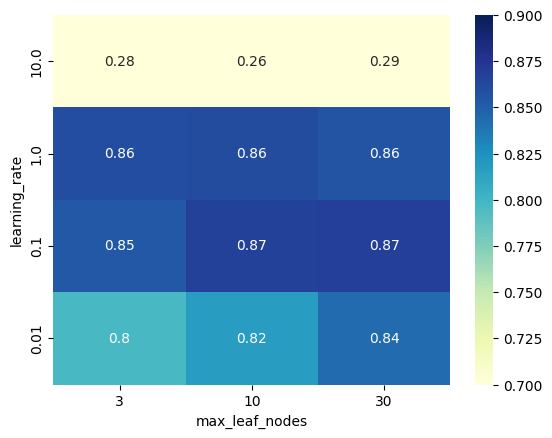

In [27]:
ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.7,
                 vmax=0.9)
ax.invert_yaxis()

The above tables highlight the following things:

- for too high values of `learning_rate`, the generalization performance of the
  model is degraded and adjusting the value of `max_leaf_nodes` cannot fix
  that problem;
- outside of this pathological region, we observe that the optimal choice
  of `max_leaf_nodes` depends on the value of `learning_rate`;
- in particular, we observe a "diagonal" of good models with an accuracy
  close to the maximal of 0.87: when the value of `max_leaf_nodes` is
  increased, one should decrease the value of `learning_rate` accordingly
  to preserve a good accuracy.


For now, we will note that, in general, **there are no unique optimal parameter
setting**: 4 models out of the 12 parameter configurations that reach the maximal
accuracy (up to small random fluctuations caused by the sampling of the
training set).
